In [14]:
import os
import pandas as pd
import py7zr
import shutil
import re
from tqdm import tqdm
import jieba
import jieba.posseg as pseg
from collections import defaultdict
import matplotlib.pyplot as plt

In [ ]:
# set up the Chinese font
plt.rc('font', family='Songti SC', size=13)

In [ ]:
# functions used to extract the data and preprocess
def extract_md_files(archive_path, extract_to):
    '''
    extract markdown files from a 7z archive
    '''
    with py7zr.SevenZipFile(archive_path, 'r') as archive:
        all_files = archive.getnames()
        md_files = [f for f in all_files if f.endswith('.md')]
        if md_files:
            archive.extract(targets=md_files, path=extract_to)
        else:
            print(f"No markdown files found in {archive_path}.")

def read_md_files_from_folder(folder_path):
    '''
    read all markdown files from a folder
    '''
    md_contents = []
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith('.md'):
                file_path = os.path.join(root, filename)
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.readlines()
                    processed_data = process_md_file(filename, content)
                    if processed_data:
                        md_contents.append(processed_data)
    return md_contents

def preprocess(df, column_name, stopwords, pattern):
    '''
    tokenize the text in a column of a dataframe and remove stopwords
    '''
    tokenized_column_name = f"{column_name}_tokenized"
    df[tokenized_column_name] = df[column_name].apply(lambda x: ''.join(re.findall(r'[\u4e00-\u9fa5]', x)))

    df[tokenized_column_name] = df[tokenized_column_name].apply(lambda x: [
        word for word in jieba.cut(x) 
        if word not in stopwords and not pattern.search(word)
    ])

    df[tokenized_column_name] = df[tokenized_column_name].apply(lambda x: ','.join(x))

def process_md_file(filename, content_lines):
    '''
    process the meta information and content of a markdown file
    '''
    date_match = re.match(r"(\d{4}-\d{2}-\d{2})", filename)
    date = date_match.group(1) if date_match else "Unknown Date"

    title_line = content_lines[0].strip() if content_lines else ""
    title_match = re.match(r"^###\s*(.+)", title_line)
    title = title_match.group(1).replace(" ", "") if title_match else "Untitled"


    content_start = 6
    content_body = []
    for line in content_lines[content_start:]:
        line = line.strip()
        if line not in title:
            content_body.append(line)

    content = "\n".join(content_body).strip()

    return {
        "date": date,
        "title": title,
        "content": content
    }

In [ ]:
# set up the paths and patterns
folder_path = 'rmrb-master/7z'
extract_to = 'mediate'

stopwords = set()
with open('baidu_stopwords.txt', 'r', encoding='utf-8') as file:
    for line in file:
        stopwords.add(line.strip())

chinese_number_pattern = re.compile(r'[零一二两三四五六七八九十百千万亿]') # Chinese numbers

# process the data
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

output_folder = 'rmrb_csv_files'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

year_range = range(1946, 2004)

for year in tqdm(year_range, desc="Processing Years"):
    year_str = f"{year}年"
    yearly_data = []
    
    for file in tqdm(os.listdir(folder_path), desc=f"Year {year}", leave=False):
        if file.startswith(year_str) and file.endswith('.7z'):
            file_path = os.path.join(folder_path, file)
            extract_md_files(file_path, extract_to)
            md_contents = read_md_files_from_folder(extract_to)
            yearly_data.extend(md_contents)

    if yearly_data:
        df = pd.DataFrame(yearly_data)
        output_path = os.path.join(output_folder, f'rmrb_{year}.csv')
        preprocess(df, 'title', stopwords, chinese_number_pattern)
        preprocess(df, 'content', stopwords, chinese_number_pattern)
        df.to_csv(output_path, index=False, encoding='utf-8')
    else:
        print(f"No data found for year {year}.")

    shutil.rmtree(extract_to)
    os.makedirs(extract_to)

print("All yearly CSV files have been saved to the folder:", output_folder)

Processing Years:   0%|          | 0/58 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/_q/5qtzmly96cj9fy0rbv42md4m0000gn/T/jieba.cache
Loading model cost 0.453 seconds.
Prefix dict has been built successfully.
Processing Years:  43%|████▎     | 25/58 [3:27:33<2:53:34, 315.61s/it]  

No markdown files found in rmrb-master/7z/1971年01月.7z.


Processing Years: 100%|██████████| 58/58 [7:24:12<00:00, 459.53s/it]  

All yearly CSV files have been saved to the folder: rmrb_csv_files


In [ ]:
# an example of the data
df = pd.read_csv('rmrb_csv_files/rmrb_2000.csv')
df.head()

date                       title  \
0  2000-06-09                 德总理访问波罗的海三国   
1  2000-06-11                  中外合作开发长庆气田   
2  2000-06-29                        不要忘本   
3  2000-06-21  十五国集团首脑会议公报强调　加强集团合作融入世界经济   
4  2000-06-18                   迟浩田会见朝鲜客人   

                                             content  \
0  德国总理施罗德五日至七日对爱沙尼亚、拉脱维亚和立陶宛进行了访问。这是波罗的海三国独立近十年来...   
1  据新华社北京6月10日电  （记者张超文）长庆石油勘探局与壳牌勘探（中国）有限公司昨天在京签...   
2  姚卿\n“吃水不忘挖井人”，这是人人都懂的道理，然而在现实生活中，一些党员干部甚至是领导干部...   
3  加强集团合作  融入世界经济\n本报开罗6月20日电 记者朱梦魁报道：为期两天的第十届15国...   
4  新华社北京6月17日电  中央军委副主席、国务委员兼国防部长迟浩田今天在北京会见了朝鲜国防委...   

               title_tokenized  \
0                 德,总理,访问,波罗的海   
1                中外合作,开发,长庆,气田   
2                           忘本   
3  国,集团,首脑会议,公报,集团,合作,融入,世界,经济   
4                 迟浩田,会见,朝鲜,客人   

                                   content_tokenized  
0  德国总理,施罗德,爱沙尼亚,拉脱维亚,立陶宛,访问,这是,波罗的海,独立,德国总理,地区,首...  
1  新华社,北京,月,日电,记者,张超文,长庆,石油勘探,局,壳牌,勘探,中国,有限公司,昨天,...  
2  姚卿,吃水,不,忘,挖井,人,人人,都,懂,道理,现实生活,中,党员干部,领导,干部,却,忘...  
3  集团,合作,融入,世界,经济,开罗,月,日电,记者,朱梦魁,报道,为期,国,集团,首脑会议,...  
4  新华社,北京,月,日电,中央军委,副,主席,国务委员,兼,国防部长,迟浩田,北京,会见,朝鲜...

In [ ]:
# count the total number of tokens and the number of tokens in each year
folder_path = "rmrb_csv_files"

unique_tokens = set()
token_year_counts = defaultdict(lambda: defaultdict(int))  # {token: {year: count}}
total_counts = defaultdict(int)  # {token: total_count}

for file_name in tqdm(os.listdir(folder_path), desc="Processing files"):
    if file_name.startswith("rmrb_") and file_name.endswith(".csv"):
        year = file_name.split('_')[1].split('.')[0]
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path, usecols=["content_tokenized"])
        for tokens in df["content_tokenized"].dropna():
            words = tokens.split(',')
            for word in words:
                unique_tokens.add(word)
                token_year_counts[word][year] += 1
                total_counts[word] += 1

year_data = []
for token in unique_tokens:
    year_counts = token_year_counts[token]
    for year, count in year_counts.items():
        year_data.append({"token": token, "year": year, "count": count})
year_token_df = pd.DataFrame(year_data)

total_data = [{"token": token, "total_count": count} for token, count in total_counts.items()]
total_token_df = pd.DataFrame(total_data)

total_token_df.to_csv("token_total_counts.csv", index=False, encoding="utf-8")

Processing files: 100%|██████████| 58/58 [28:48<00:00, 29.81s/it]


In [ ]:
# function used to get the part of speech of a word
def get_pos(word):
    words = pseg.cut(word)
    for w in words:
        return w.flag

In [ ]:
# get the part of speech of each token in the dictionary
total_token_df = pd.read_csv("token_total_counts.csv")

total_token_df['pos'] = total_token_df['token'].apply(get_pos)

total_token_df.to_csv("tokens_with_pos.csv", index=False, encoding="utf-8")

In [ ]:
# only include nouns, verbs, and adjectives
valid_pos_tags = ["n", "nr", "ns", "nt", "nz",  
                  "v", "vn",                  
                  "a", "ad", "an"]            

In [ ]:
# filter the tokens
filtered_df = total_token_df[(total_token_df['pos'].isin(valid_pos_tags)) & (total_token_df['token'].str.len() > 1)]

In [ ]:
# most frequent tokens
filtered_df.sort_values(by='total_count', ascending=False).head(10)

token  total_count pos
282     人民     11254859   n
542     中国      9702048  ns
1613    工作      8709047  vn
731     发展      8126300  vn
460     国家      6759309   n
421     生产      6568260  vn
595     美国      5414785  ns
636     经济      4912482   n
3439    革命      4811365  vn
366    新华社      4602094  nt

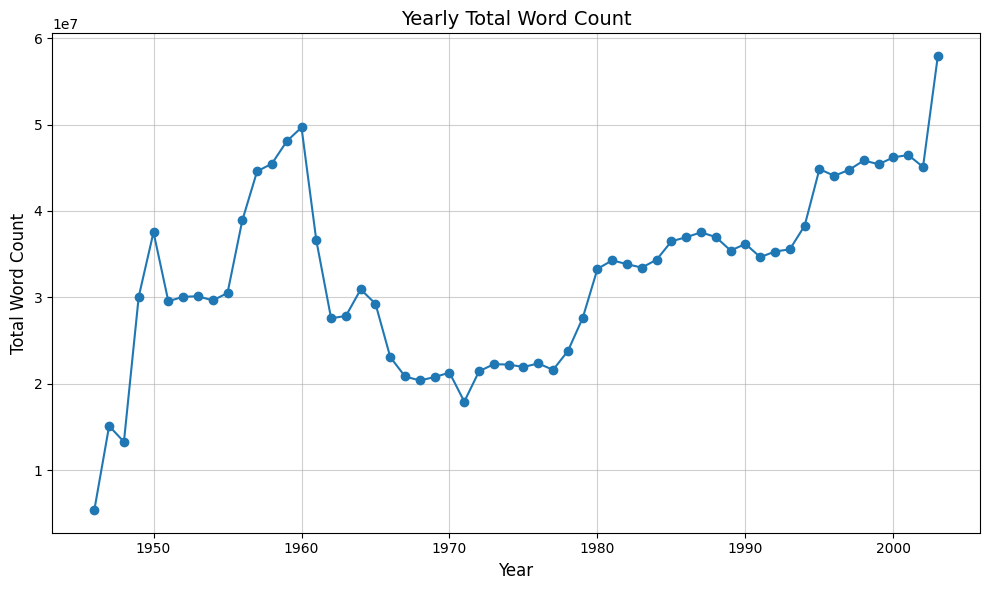

In [ ]:
# plot the total word count over the years
yearly_total_counts = year_token_df.groupby("year")["count"].sum().reset_index()
yearly_total_counts.columns = ["year", "total_word_count"]

plt.figure(figsize=(10, 6))
plt.plot(yearly_total_counts["year"], yearly_total_counts["total_word_count"], marker='o', linestyle='-')
plt.title("Yearly Total Word Count", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Word Count", fontsize=12)
plt.grid(alpha=0.6)
plt.tight_layout()

plt.show()

In [ ]:
# add the frequency to the dataframe, which can be compared across years
year_total_dict = yearly_total_counts.set_index("year")["total_word_count"].to_dict()

year_token_df["frequency"] = year_token_df.apply(
    lambda row: row["count"] / year_total_dict[row["year"]], axis=1
)

In [ ]:
# save the dataframe
year_token_df.to_csv("token_year_counts.csv", index=False, encoding="utf-8")

In [ ]:
# function used to plot the frequency of a word over the years
def plot_word_frequency(word, smoothing_window=None):
    women_df = year_token_df[(year_token_df['token'] == word) & (year_token_df['year'] > 1948)]
    
    full_years = pd.DataFrame({"year": range(1949, year_token_df['year'].max() + 1)})
    women_df = full_years.merge(women_df, on="year", how="left").fillna({"frequency": 0})
    
    women_df = women_df.sort_values(by="year")

    if smoothing_window:
        women_df["smoothed_frequency"] = (
            women_df["frequency"].rolling(window=smoothing_window, center=True).mean()
        )
    else:
        women_df["smoothed_frequency"] = women_df["frequency"]

    plt.figure(figsize=(5, 3))
    plt.plot(women_df["year"], women_df["smoothed_frequency"], marker='o', linestyle='-')
    plt.title("Yearly Relative Frequency of " + word, fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()

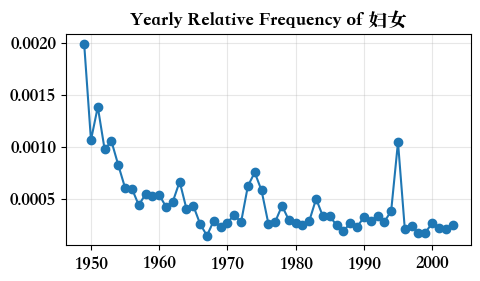

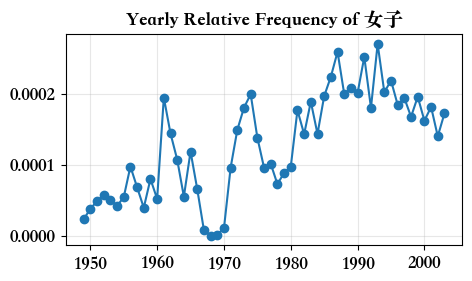

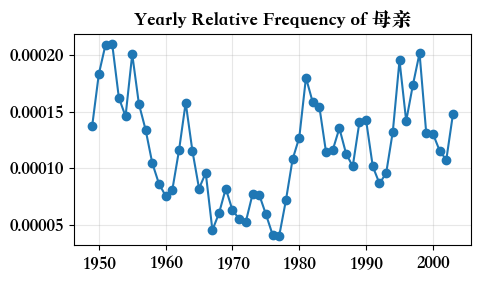

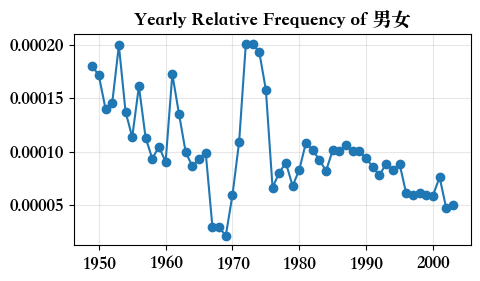

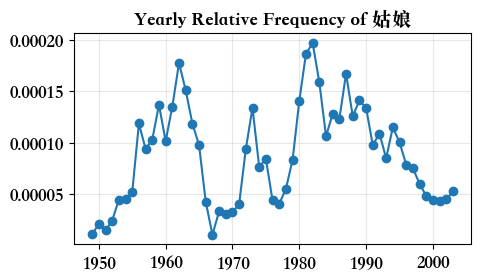

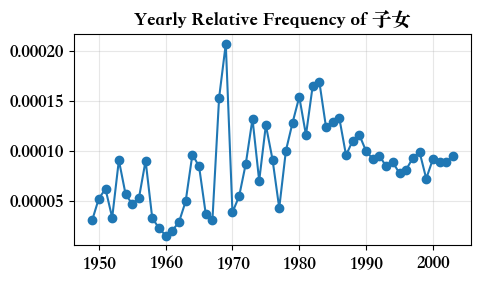

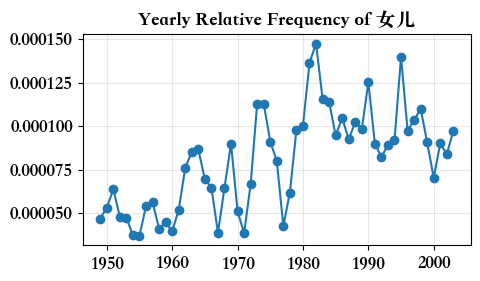

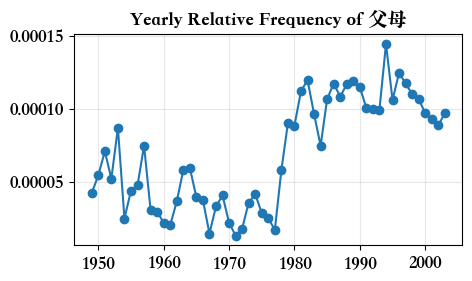

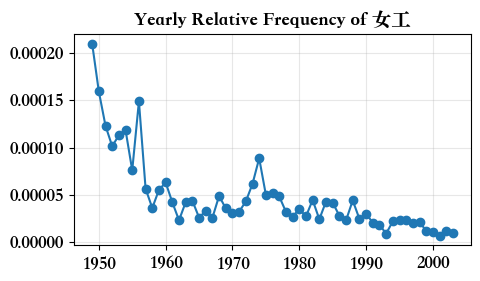

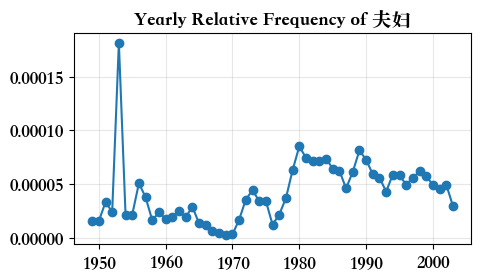

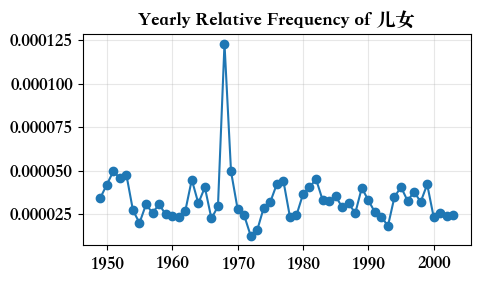

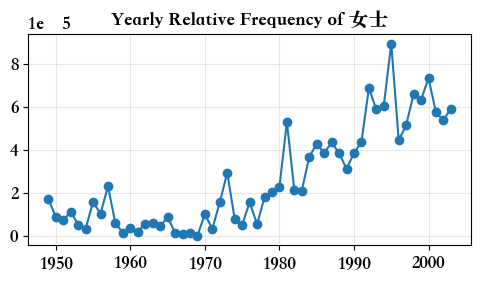

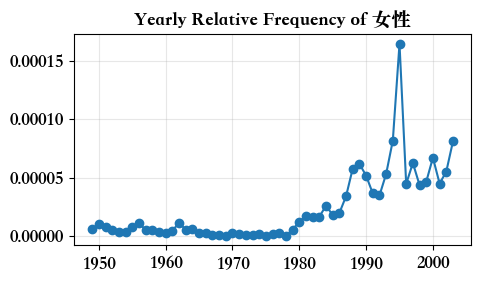

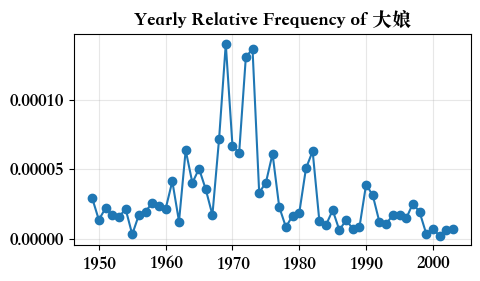

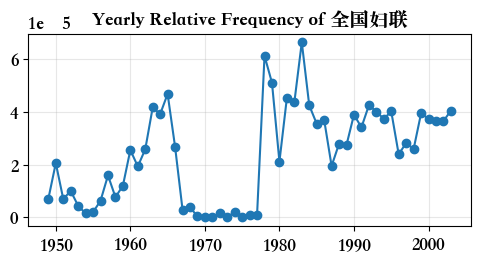

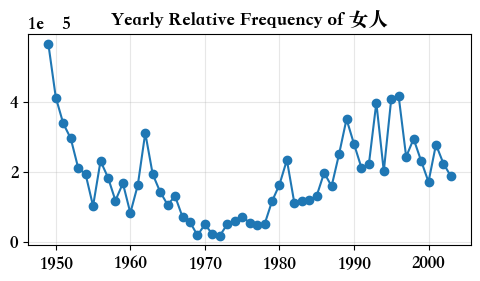

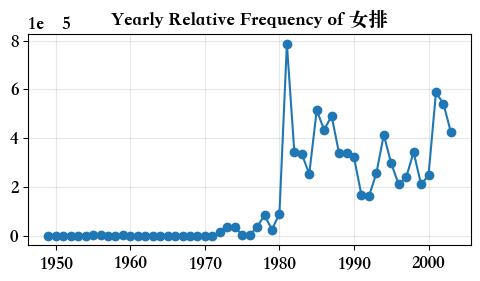

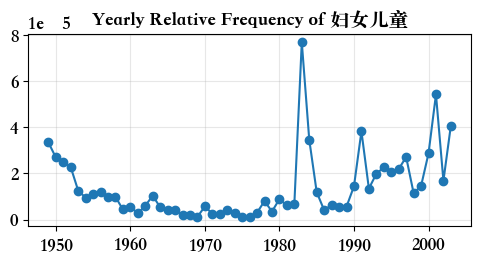

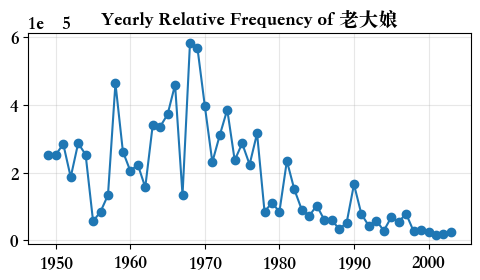

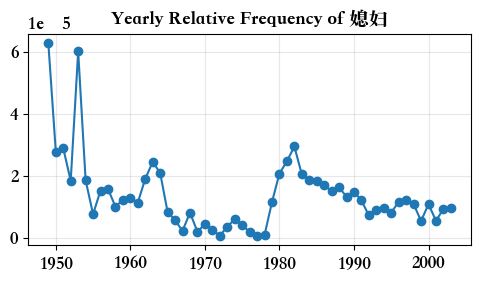

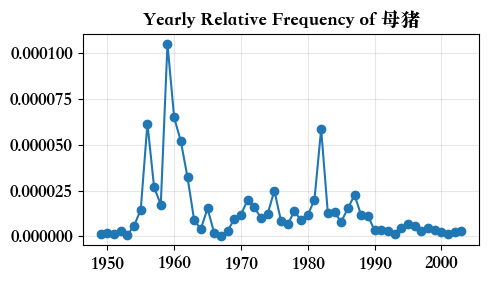

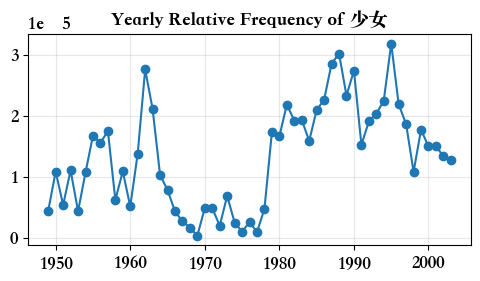

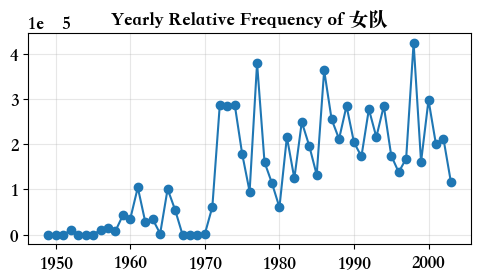

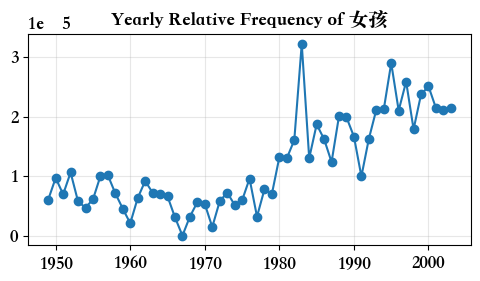

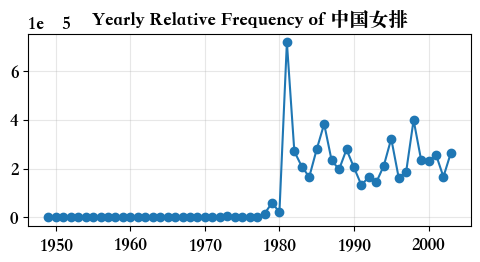

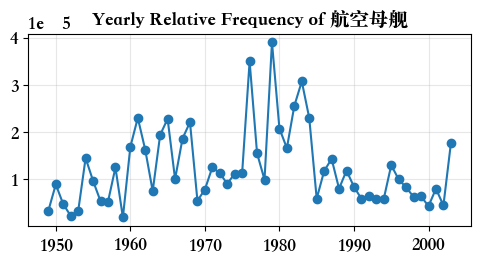

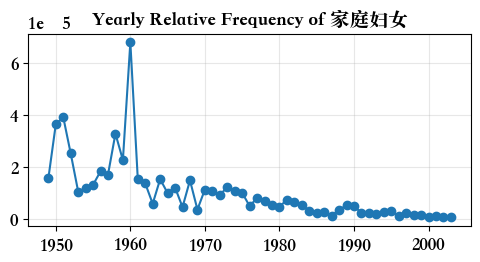

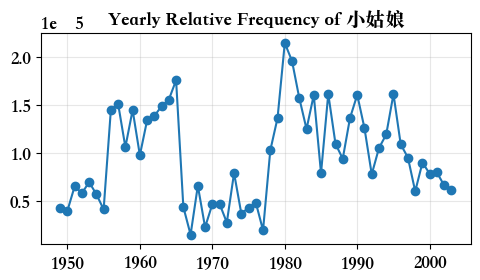

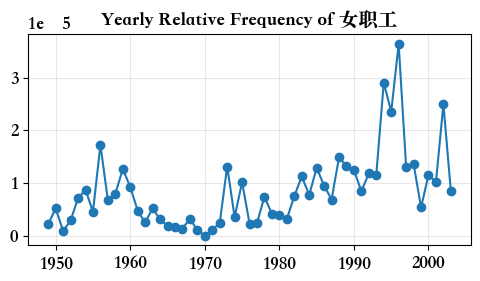

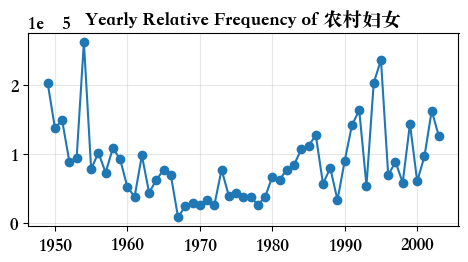

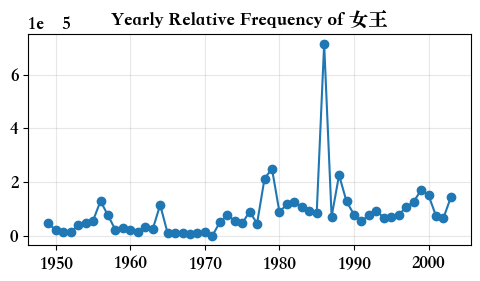

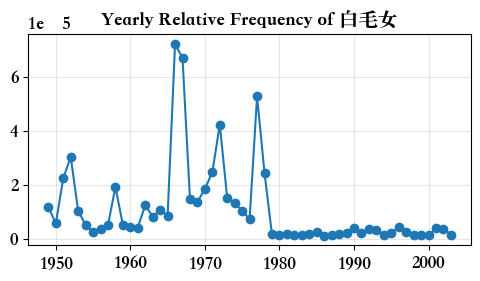

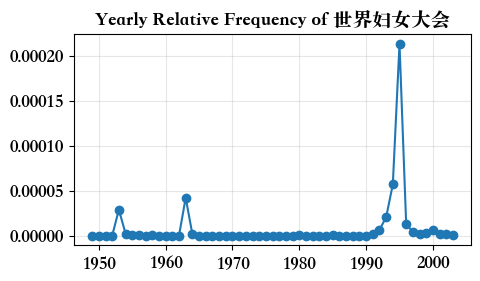

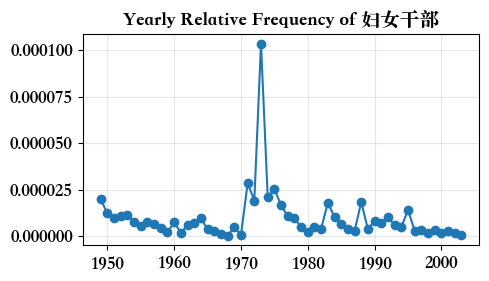

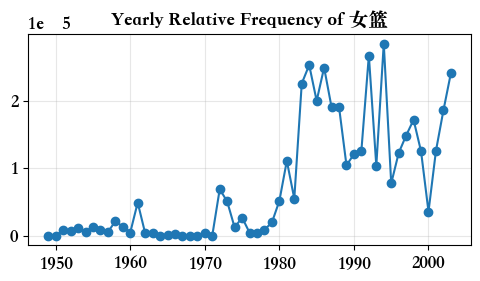

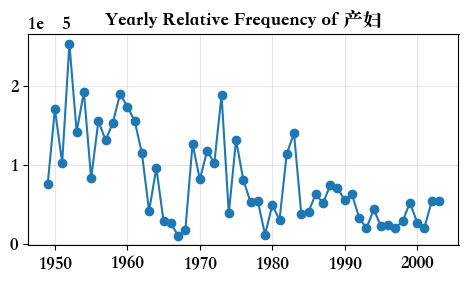

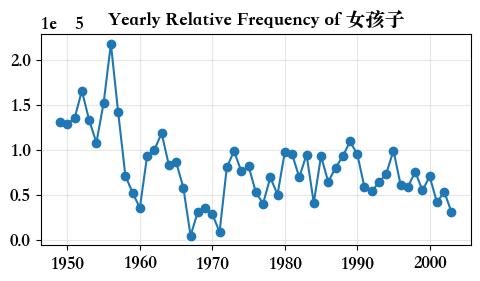

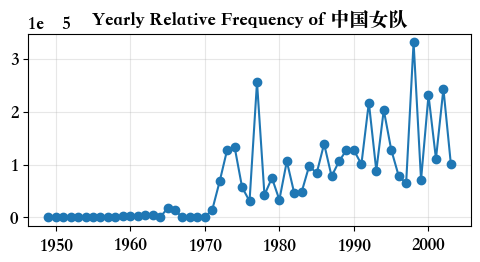

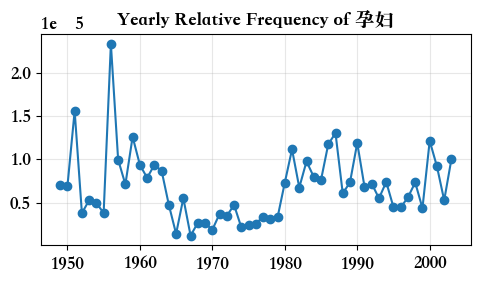

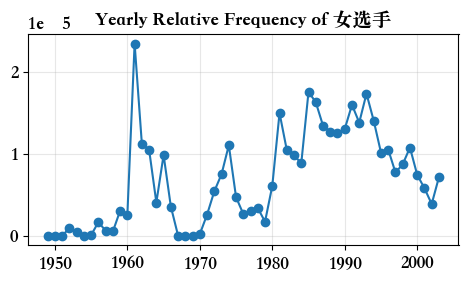

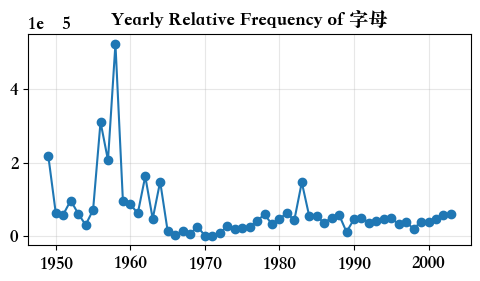

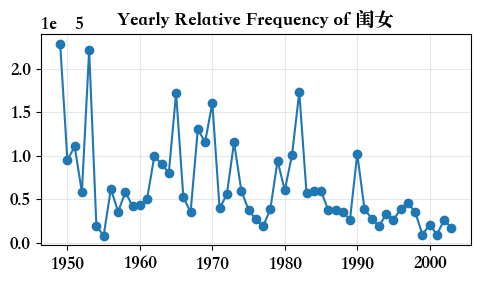

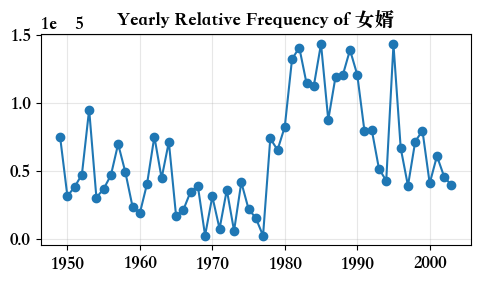

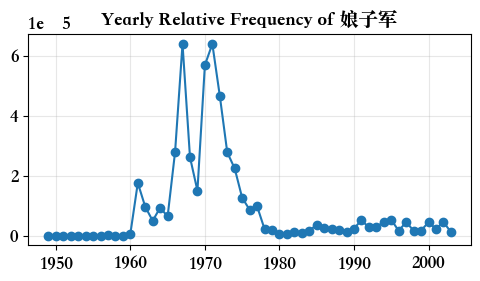

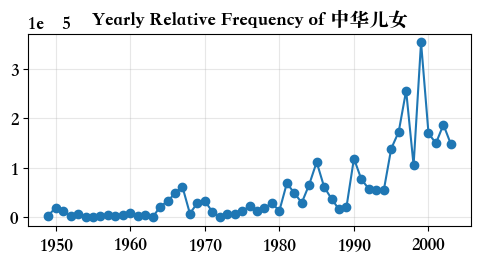

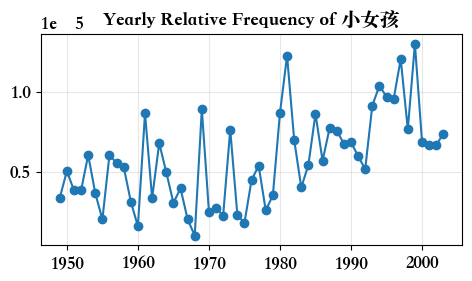

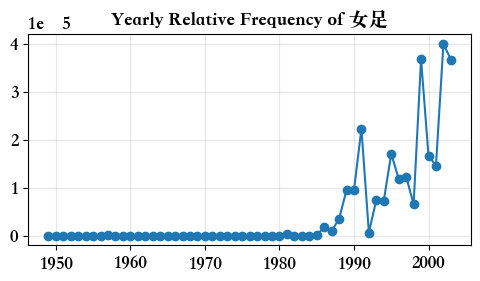

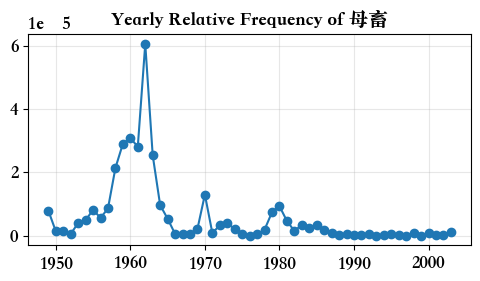

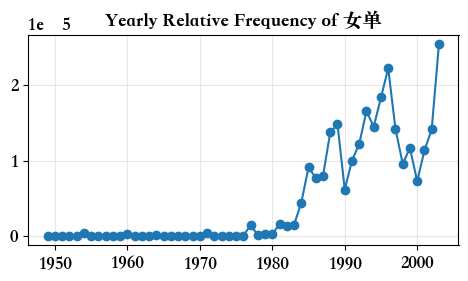

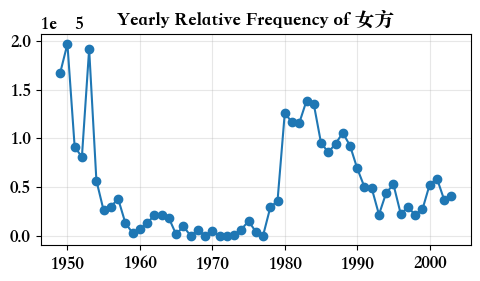

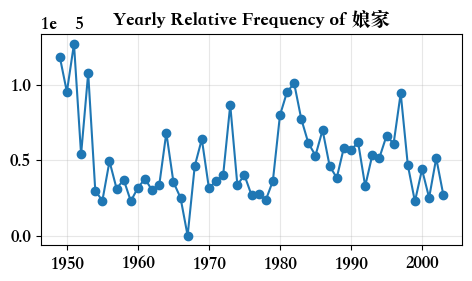

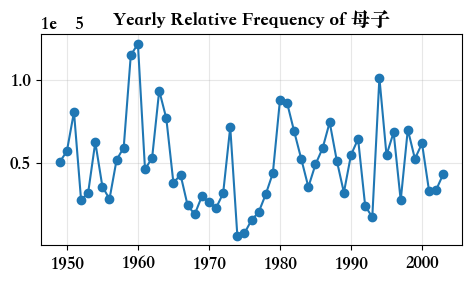

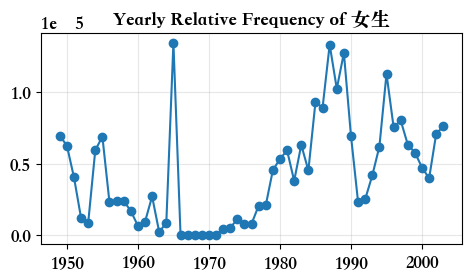

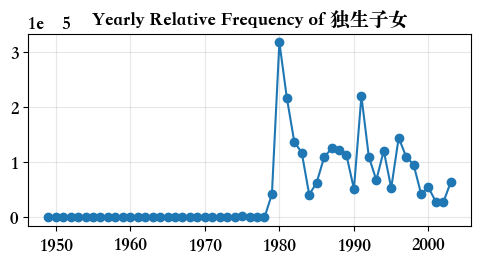

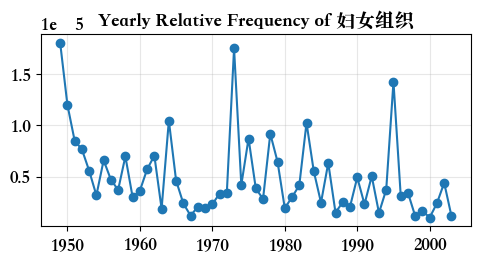

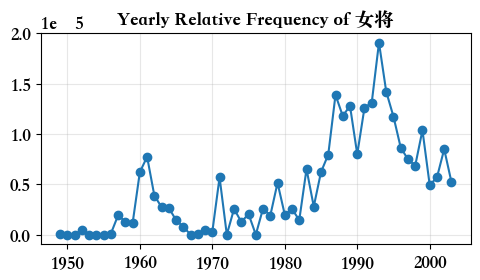

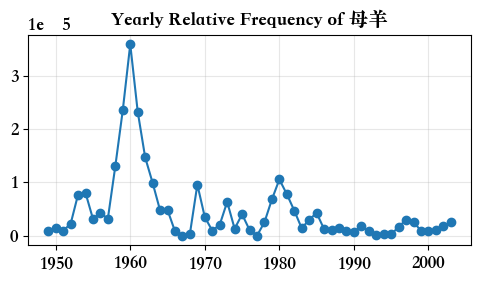

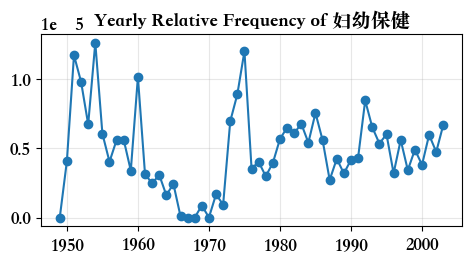

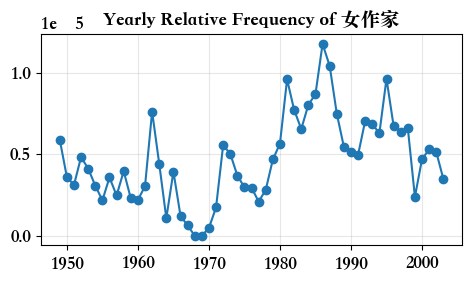

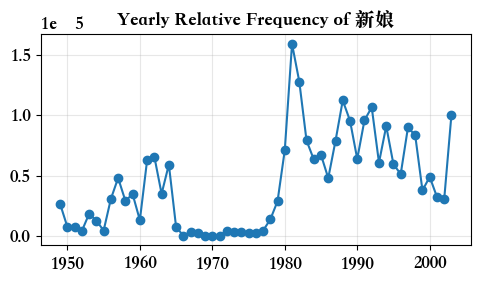

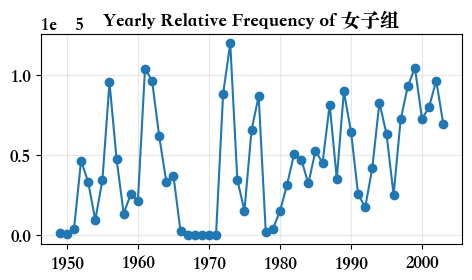

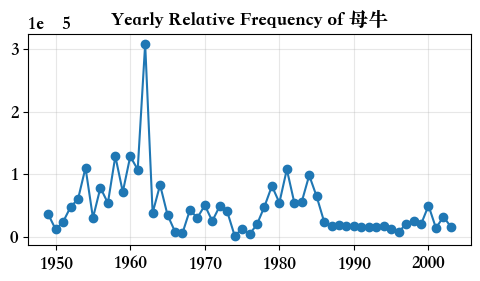

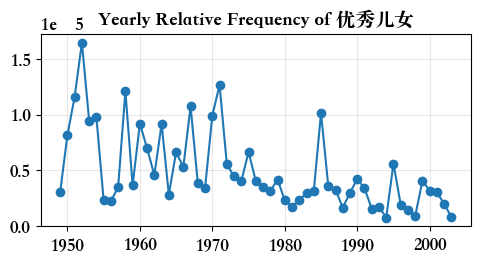

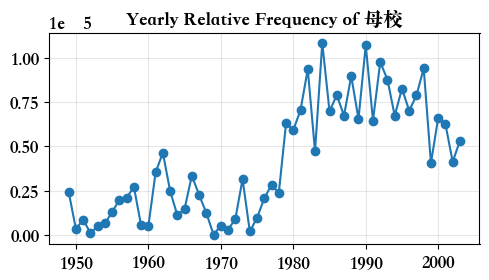

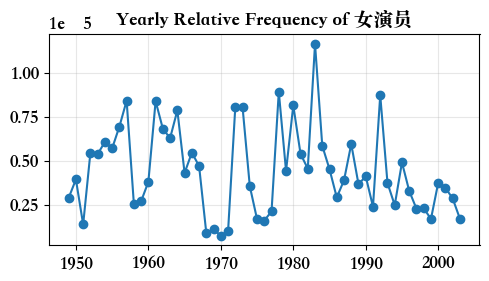

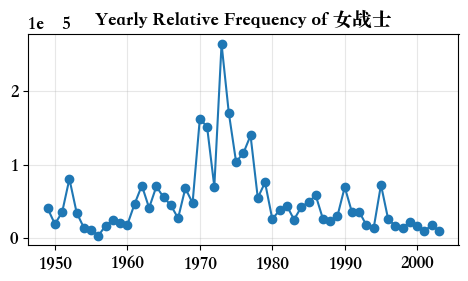

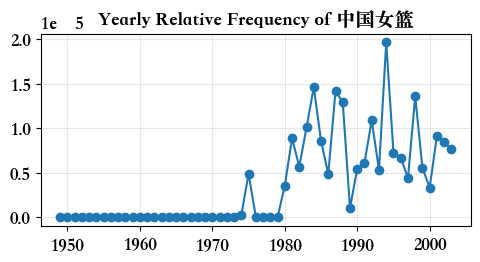

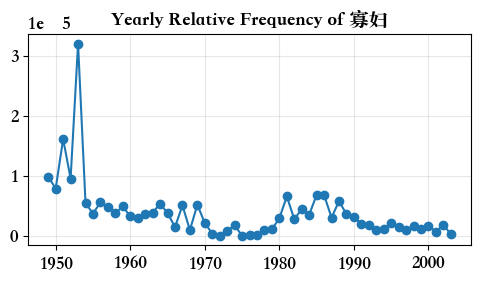

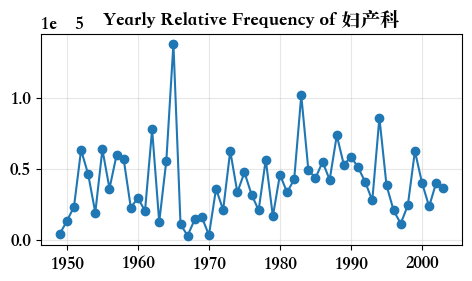

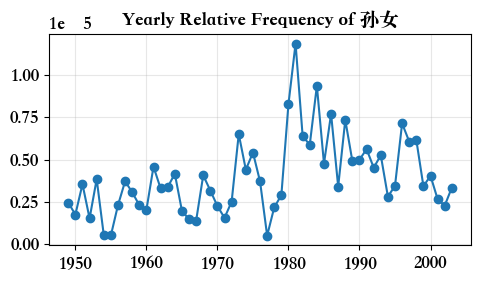

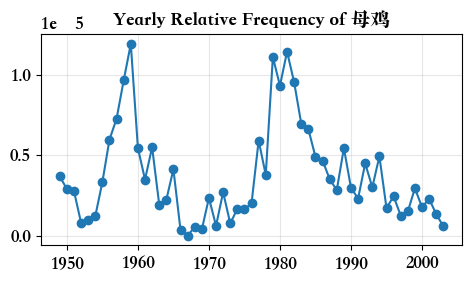

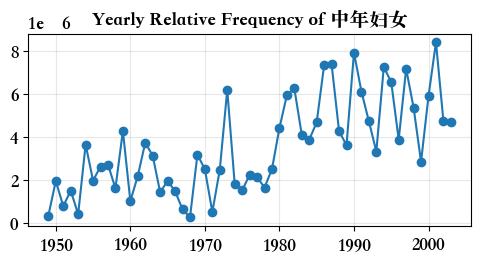

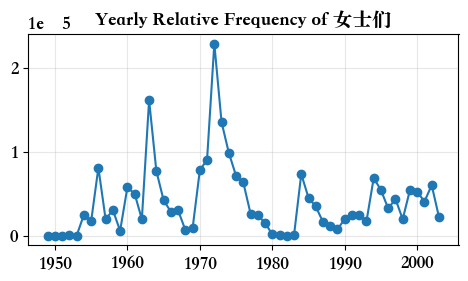

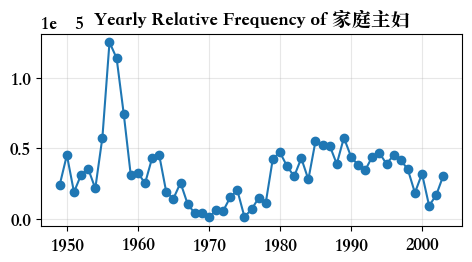

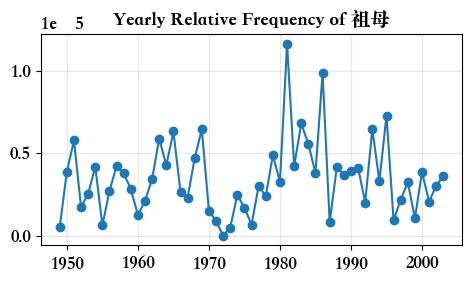

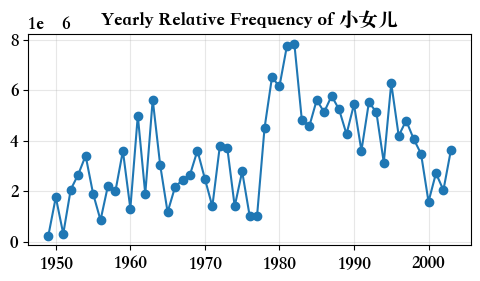

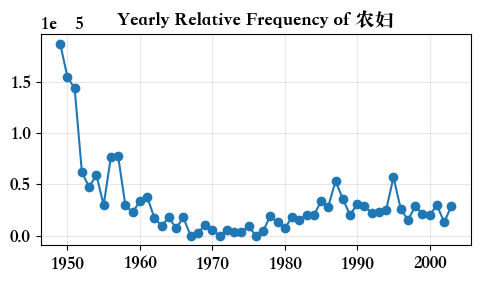

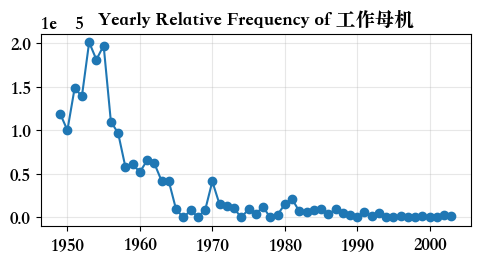

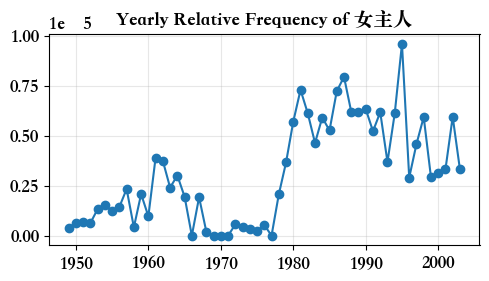

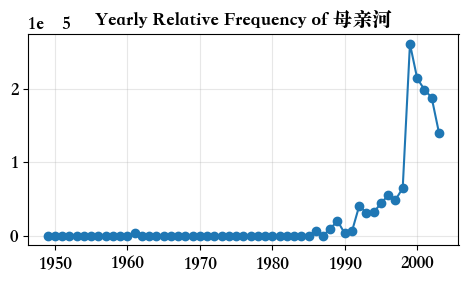

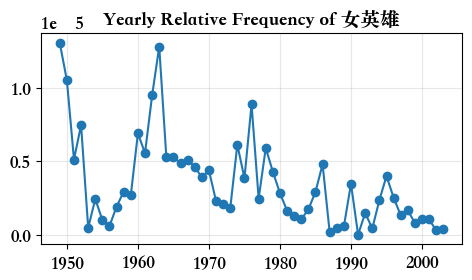

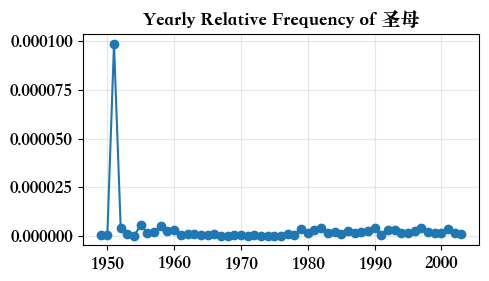

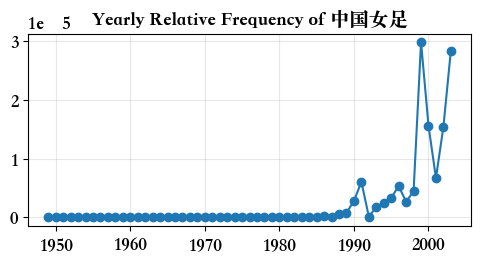

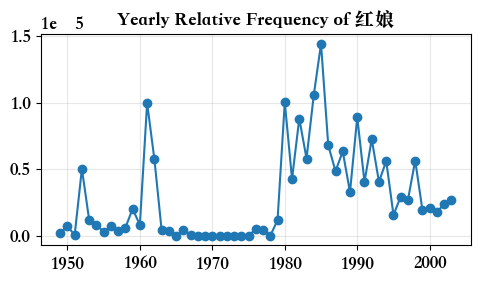

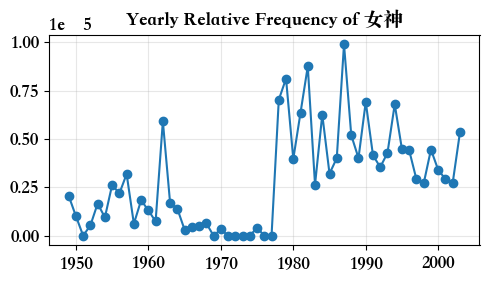

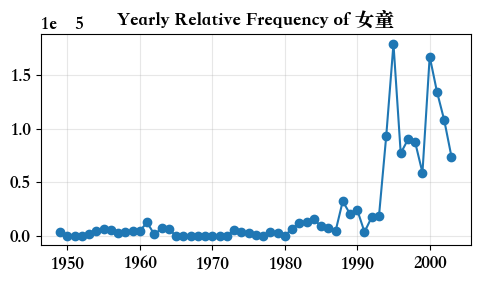

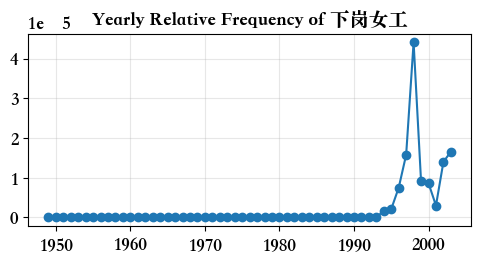

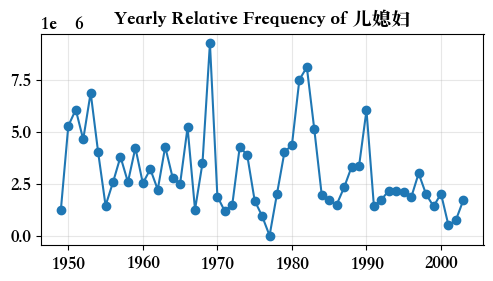

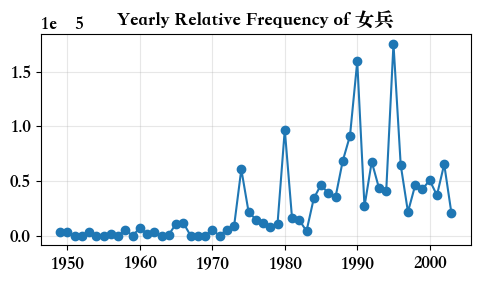

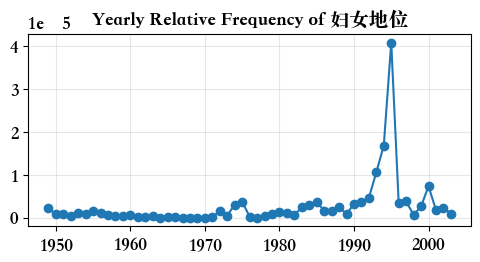

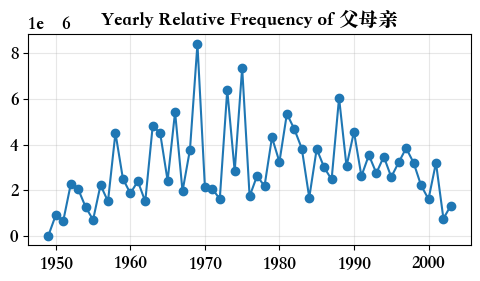

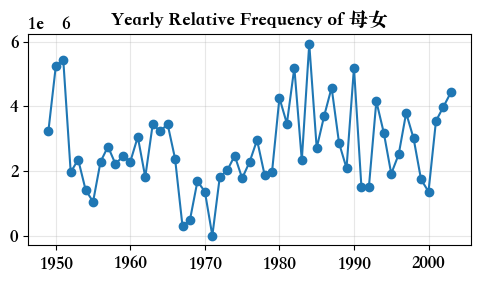

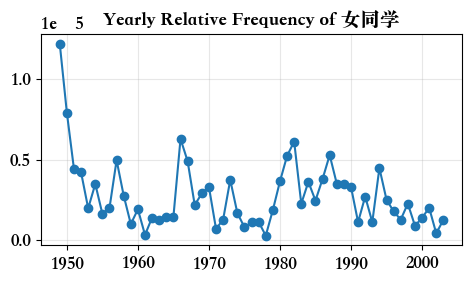

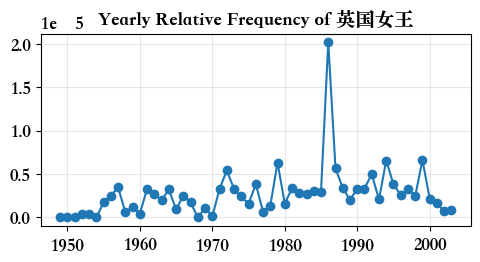

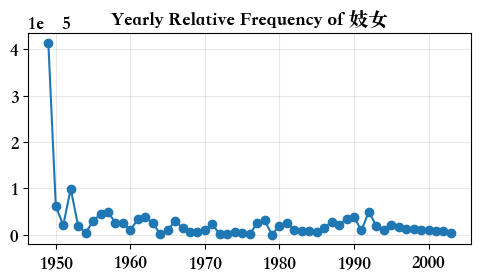

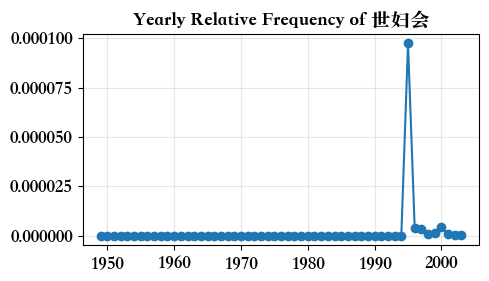

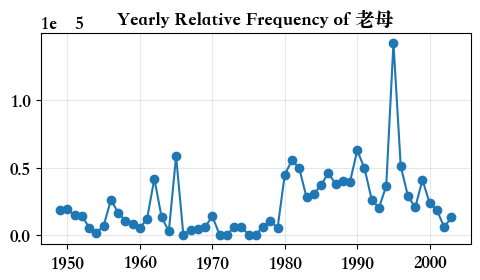

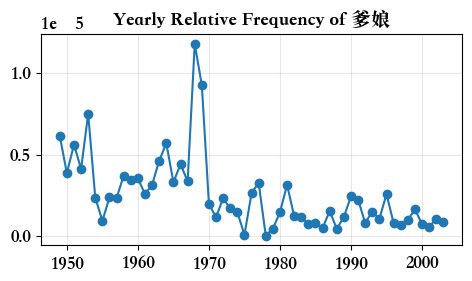

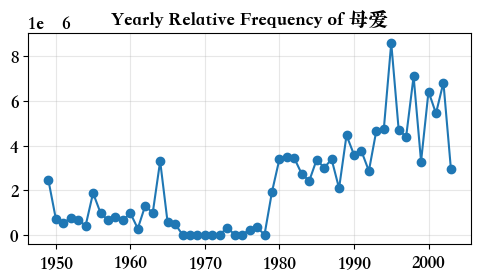

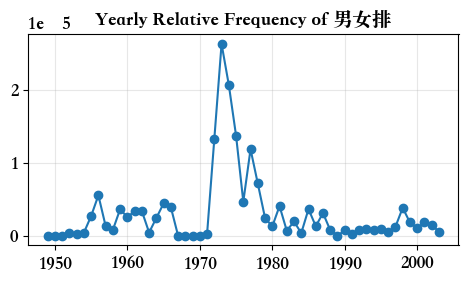

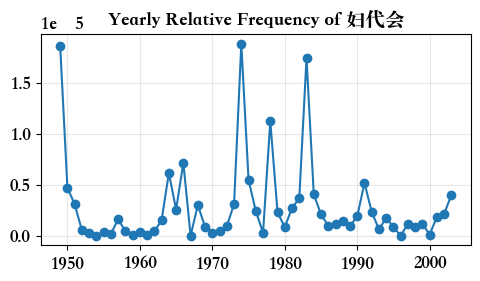

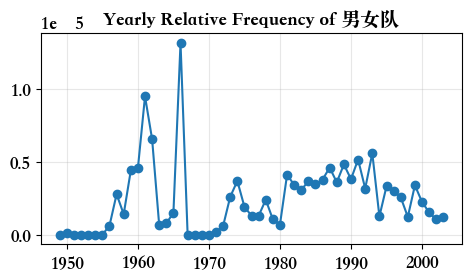

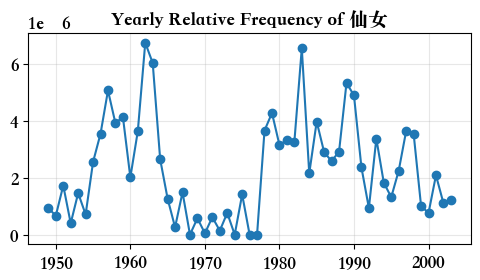

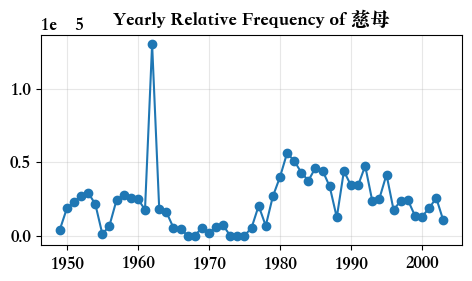

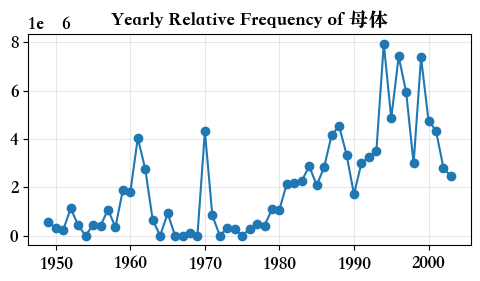

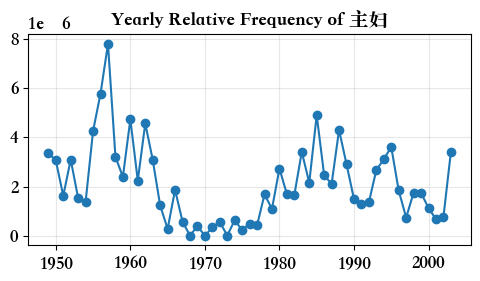

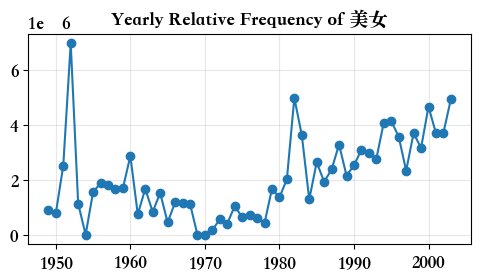

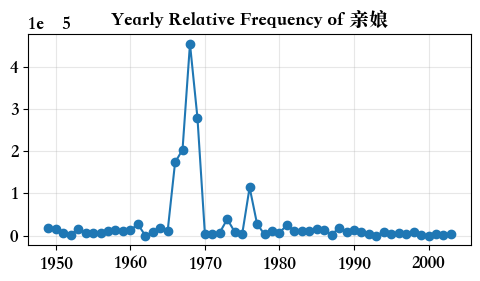

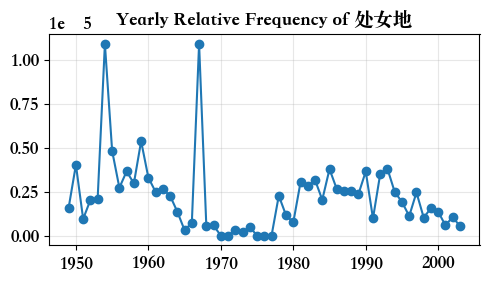

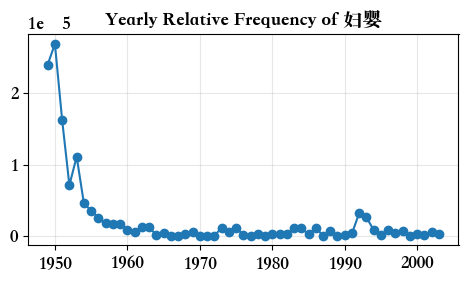

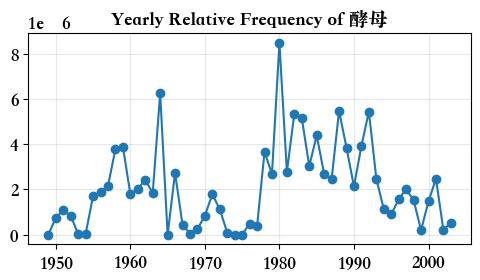

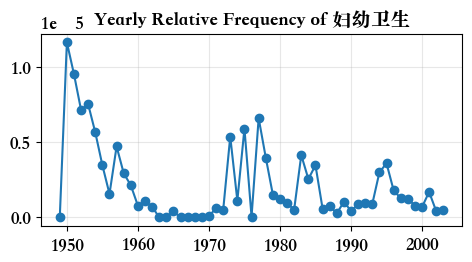

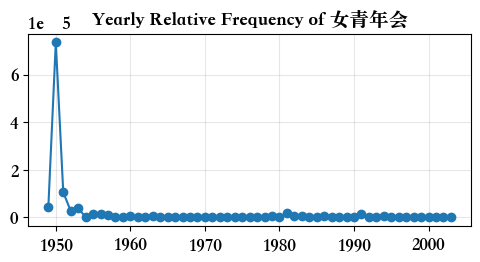

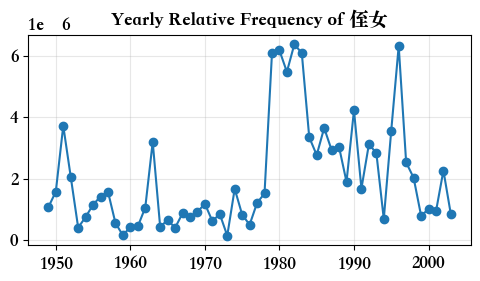

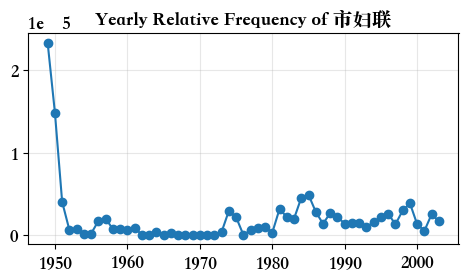

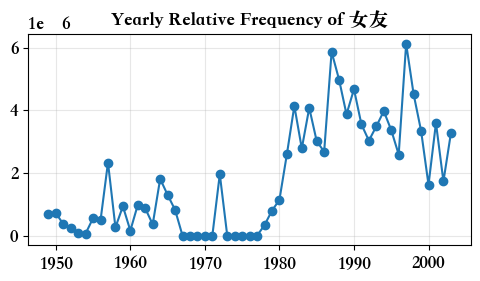

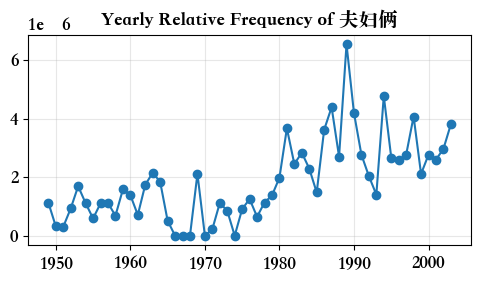

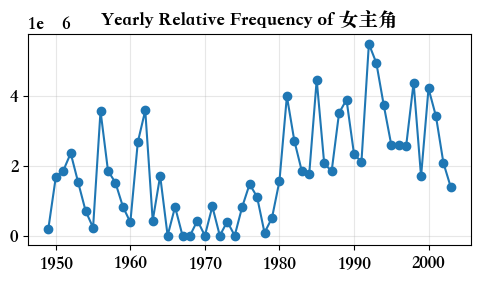

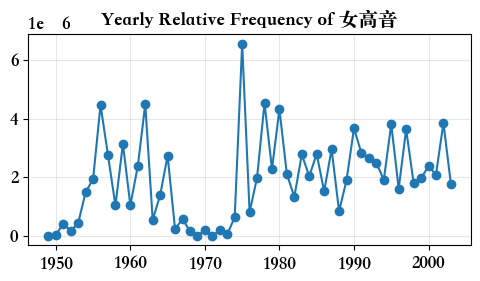

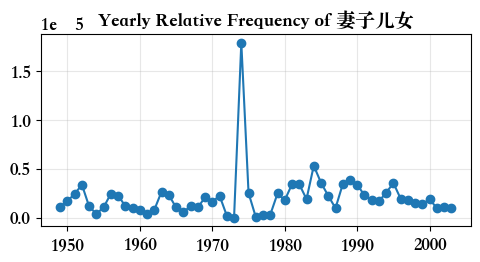

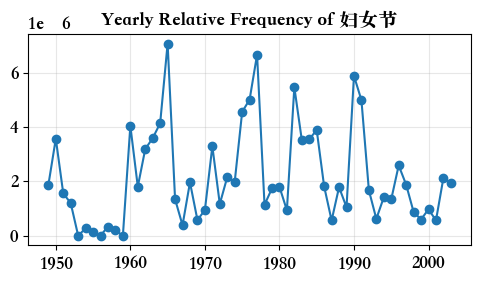

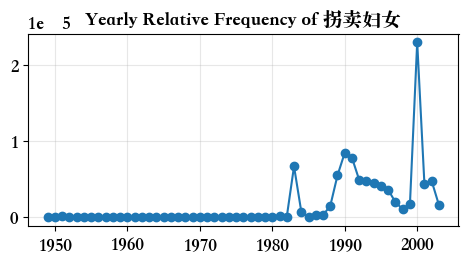

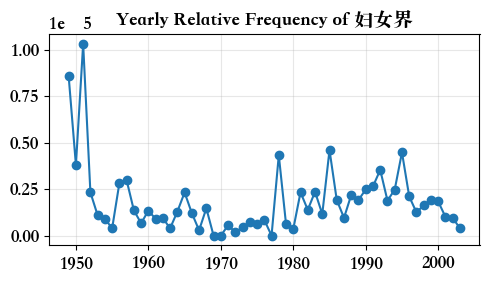

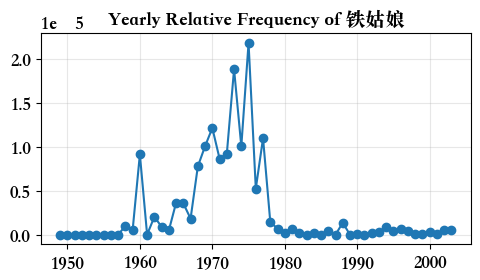

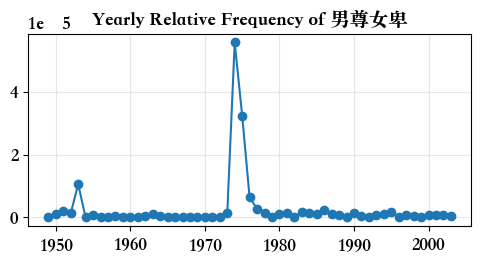

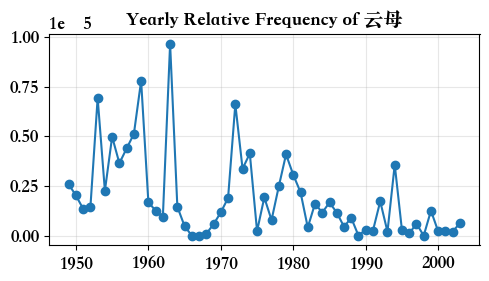

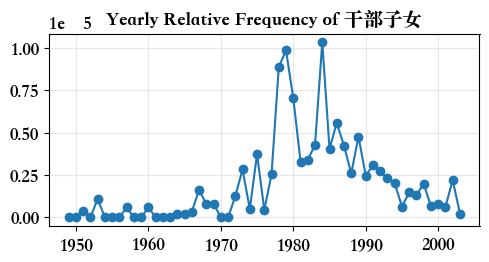

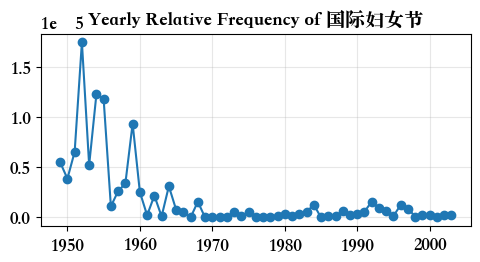

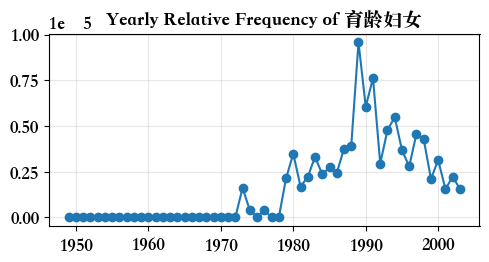

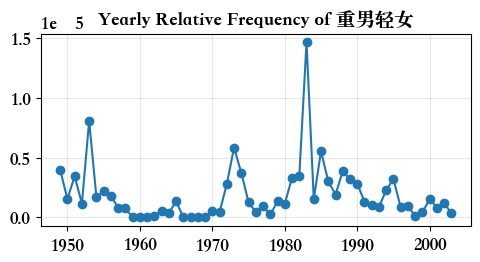

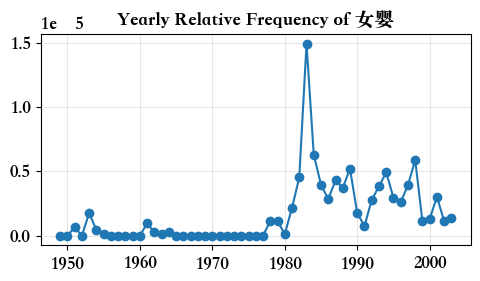

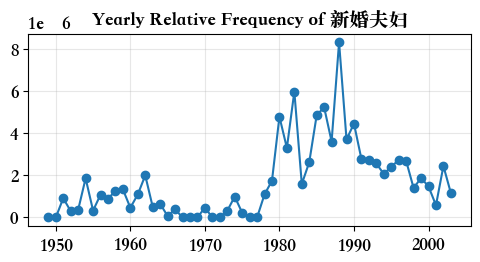

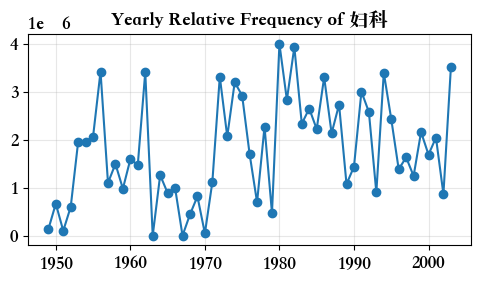

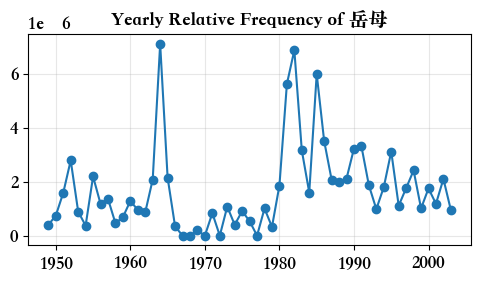

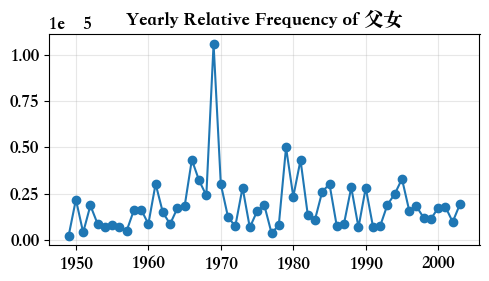

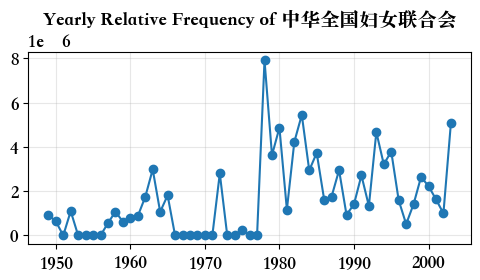

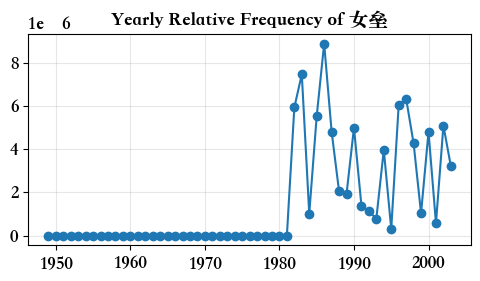

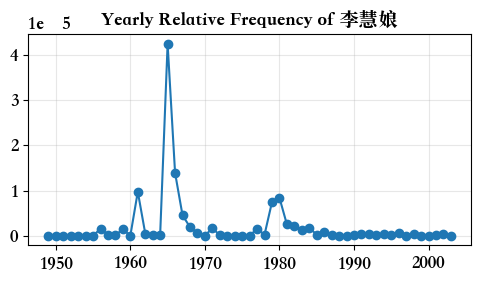

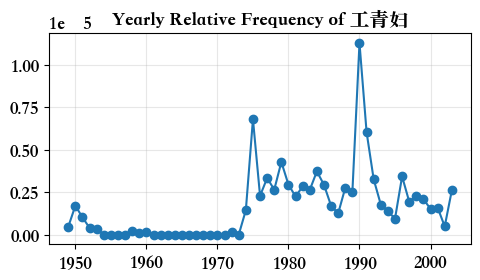

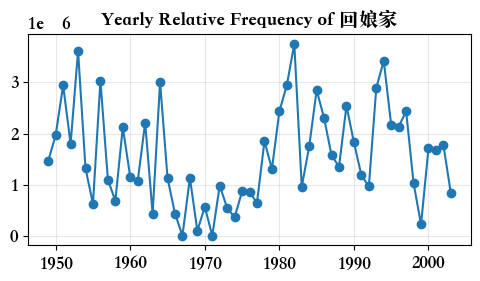

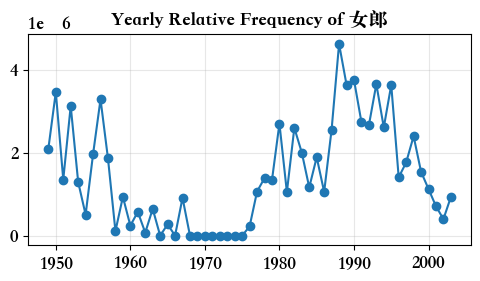

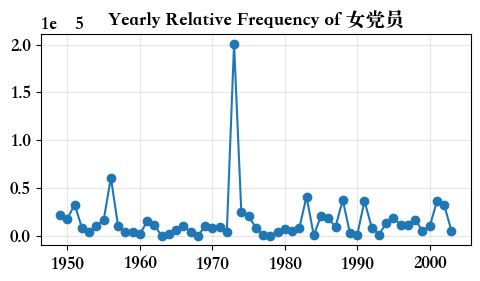

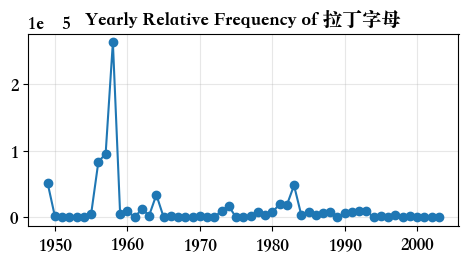

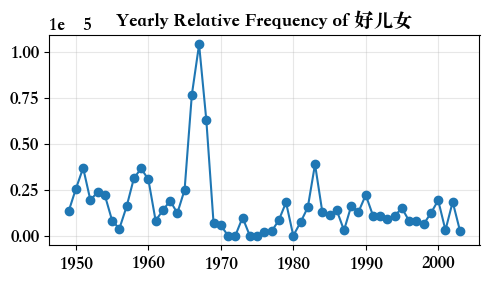

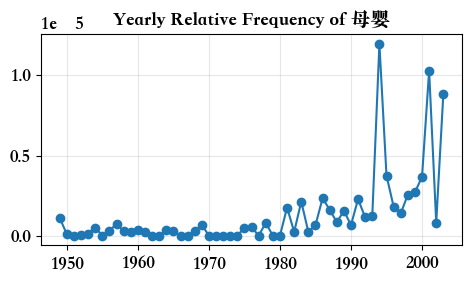

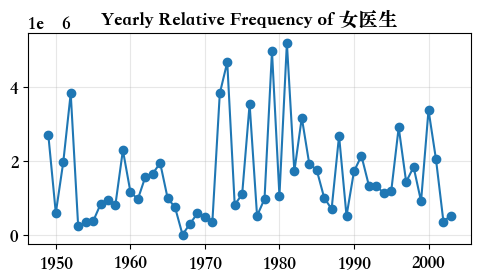

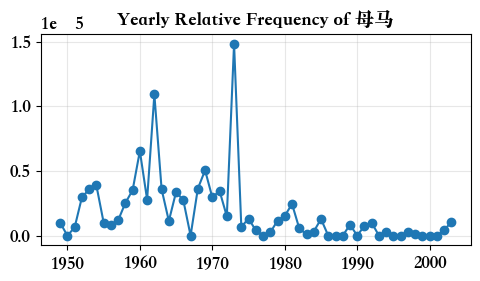

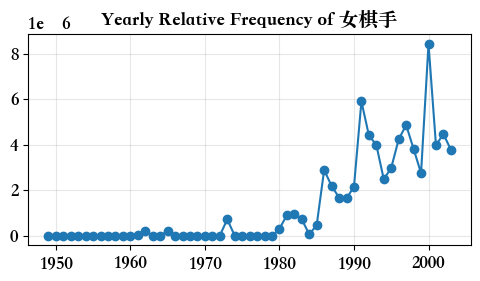

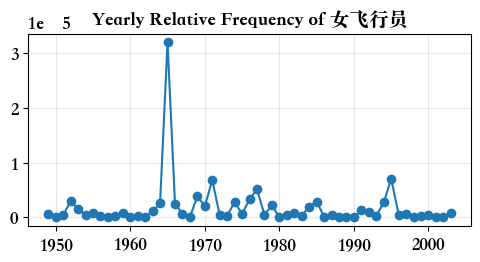

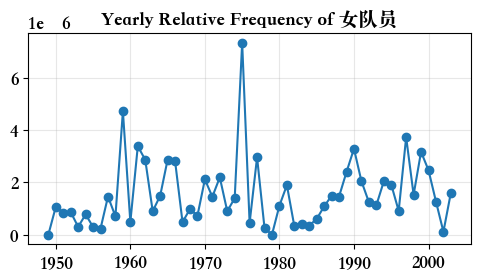

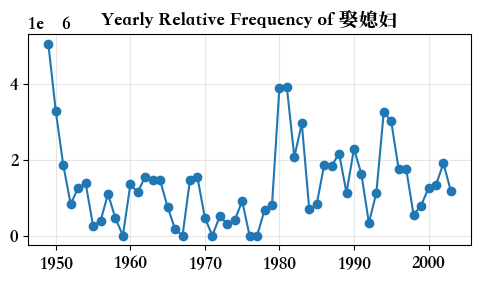

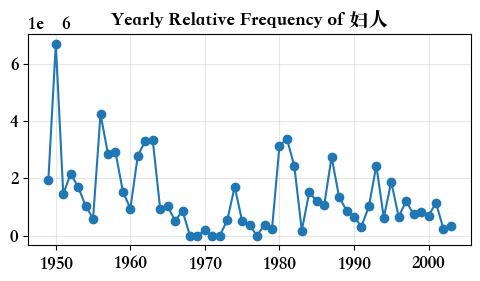

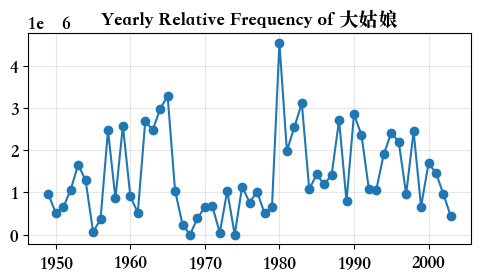

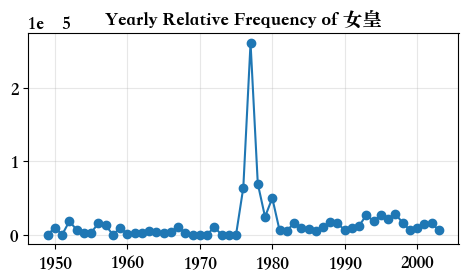

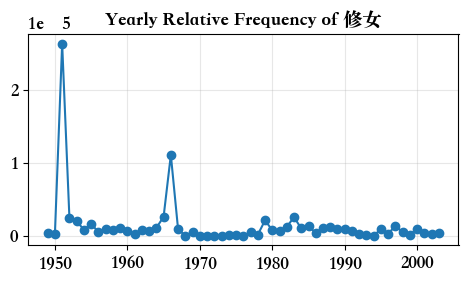

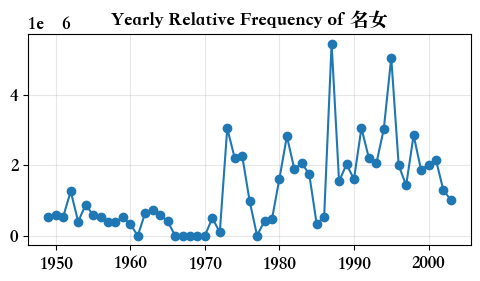

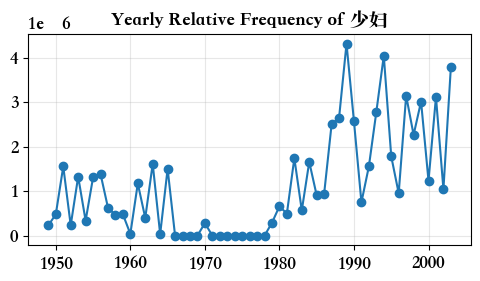

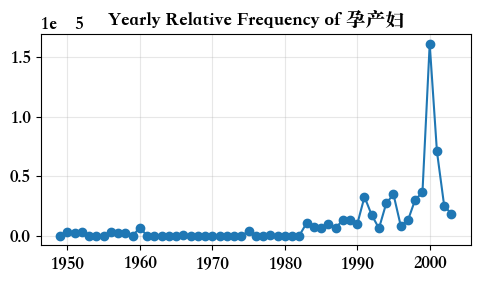

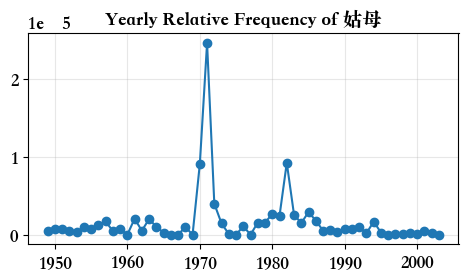

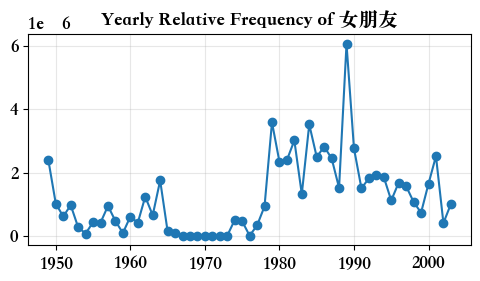

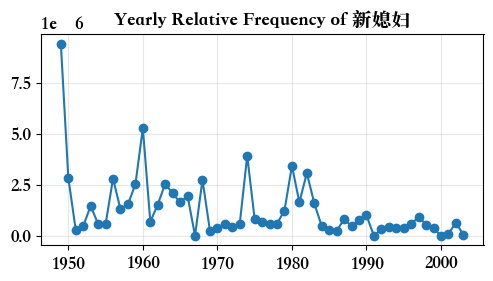

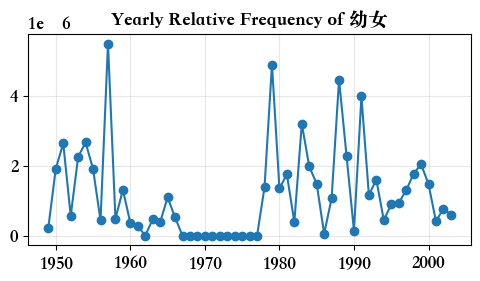

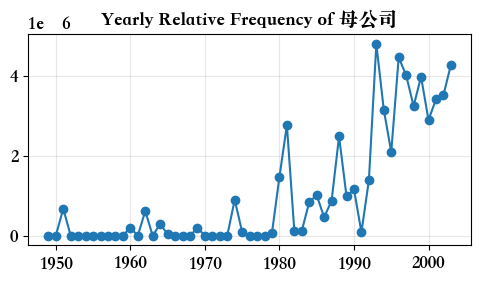

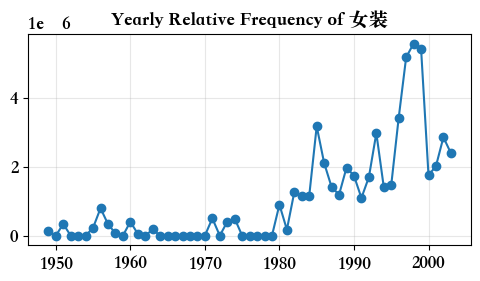

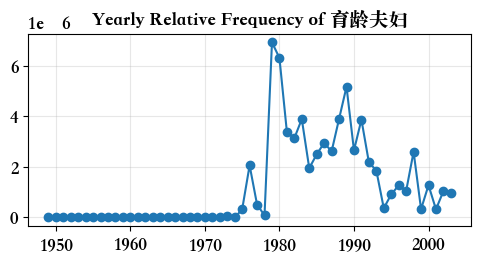

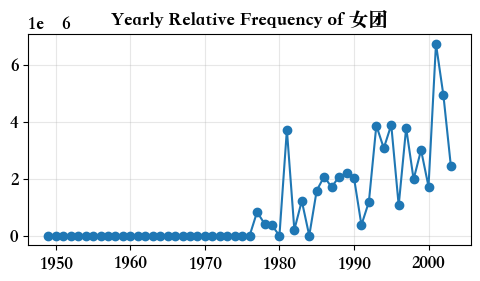

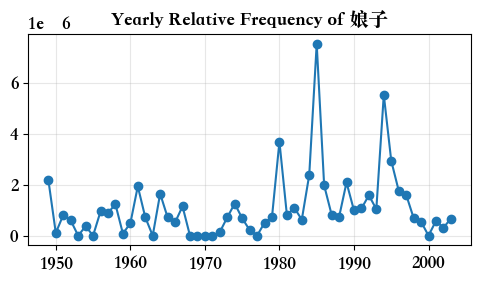

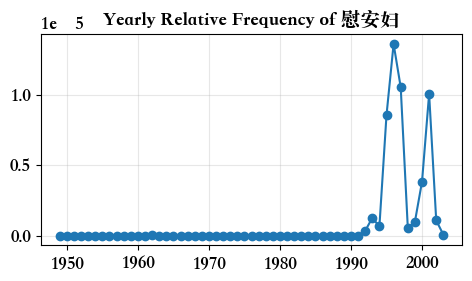

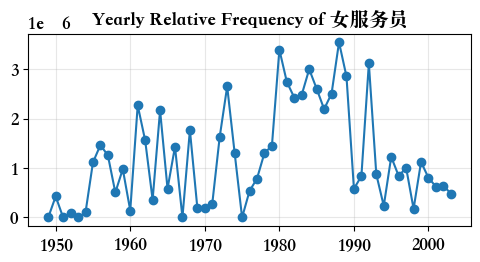

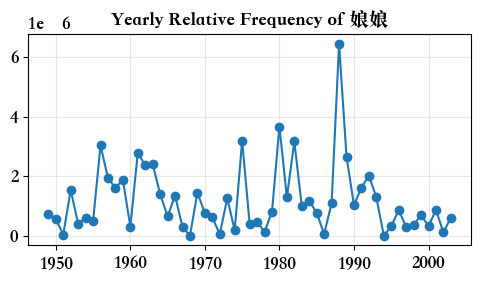

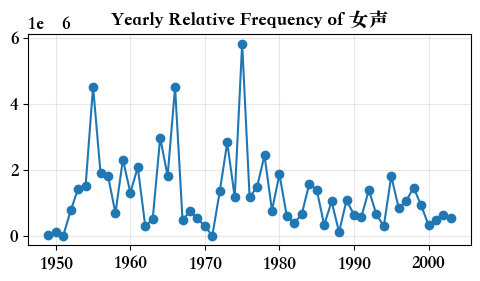

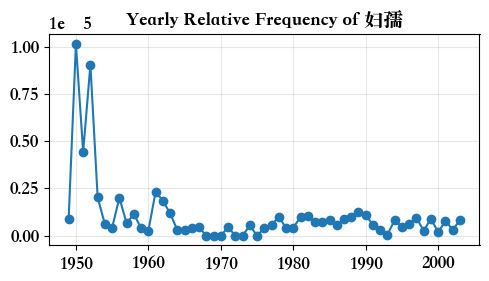

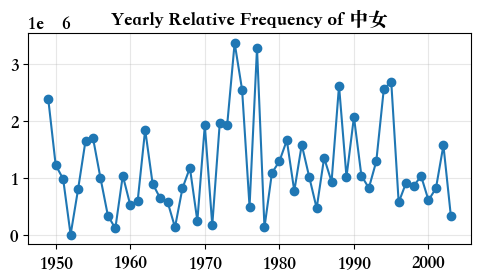

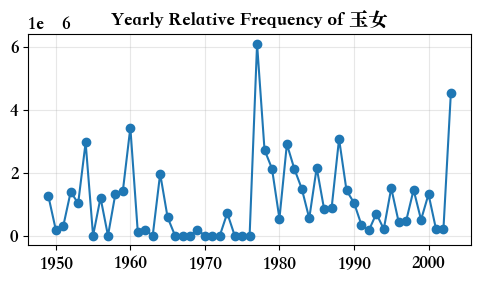

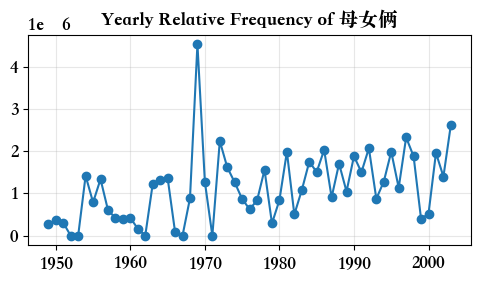

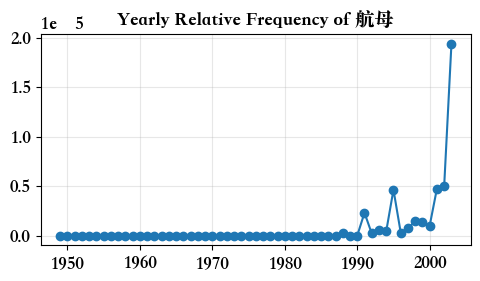

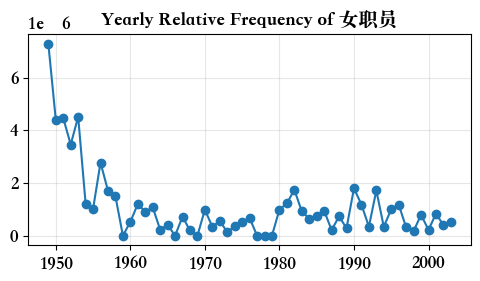

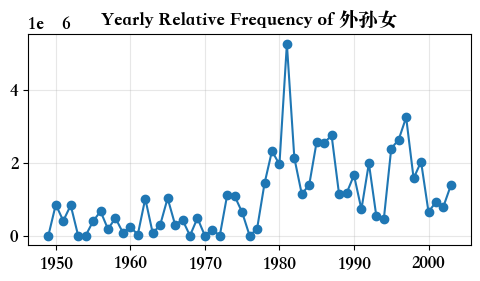

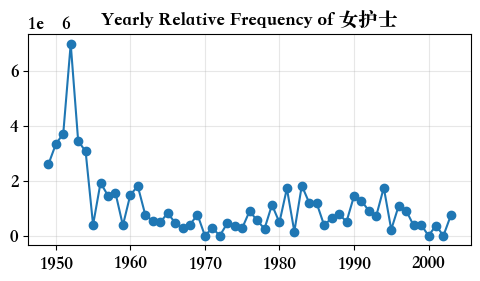

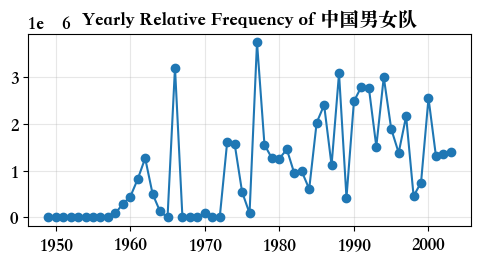

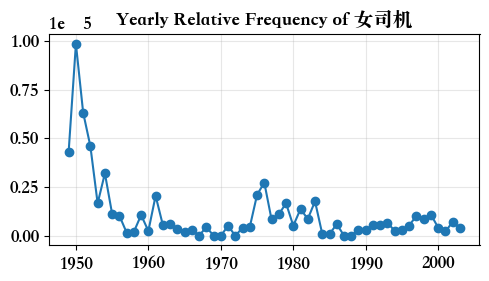

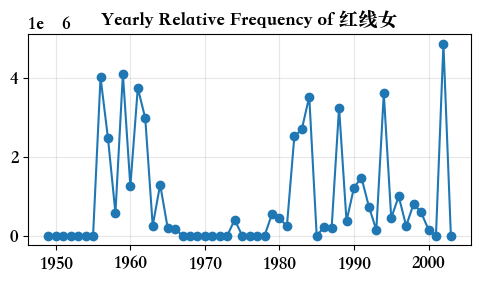

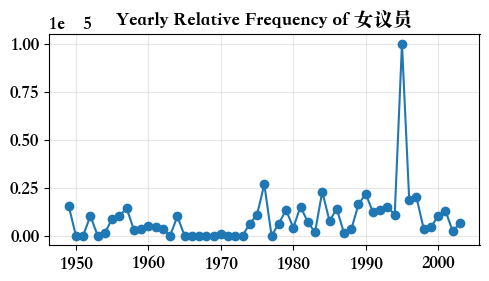

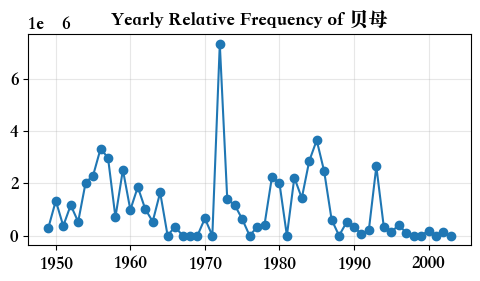

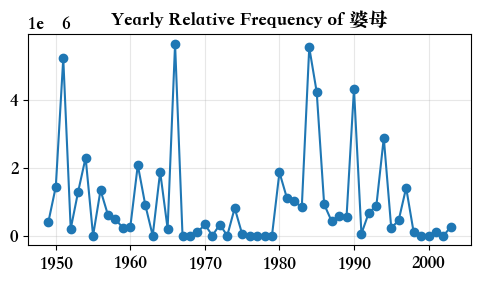

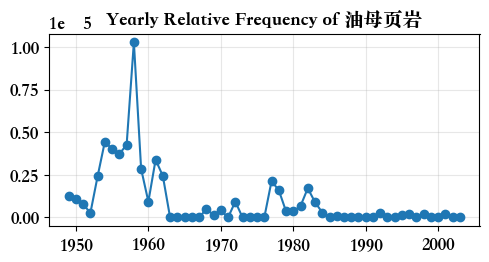

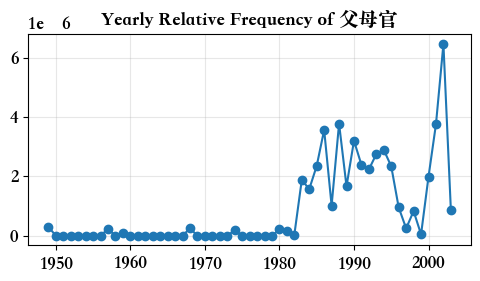

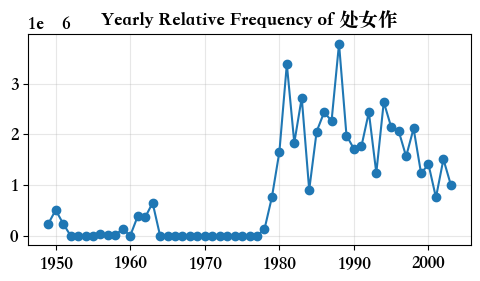

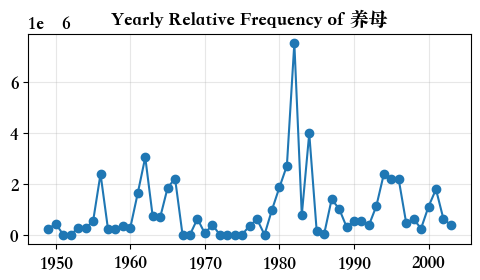

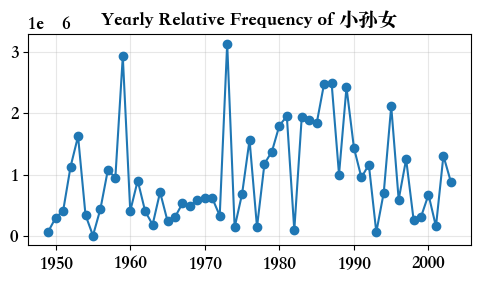

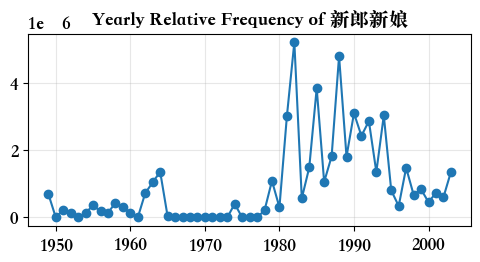

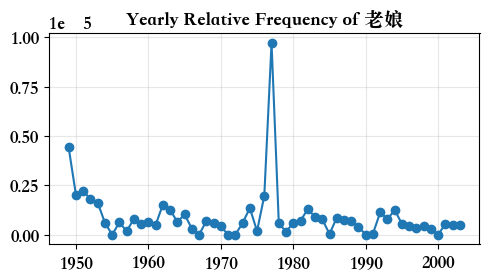

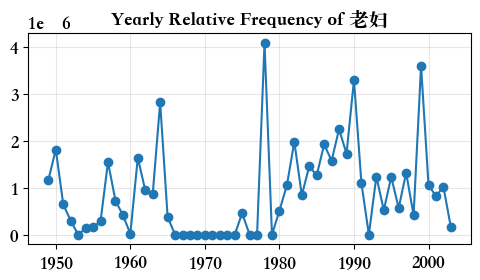

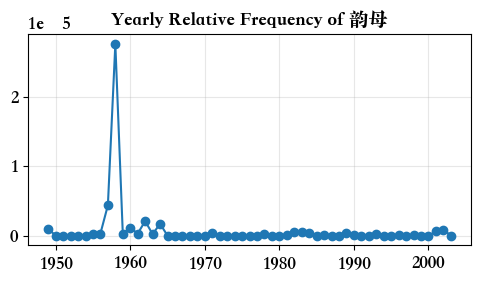

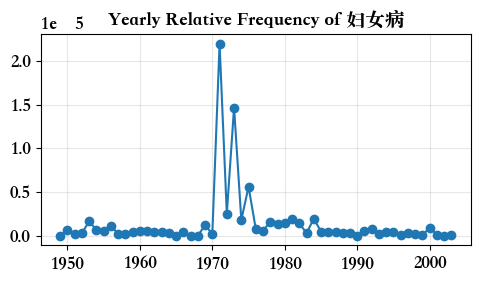

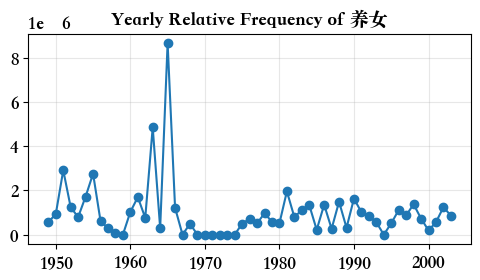

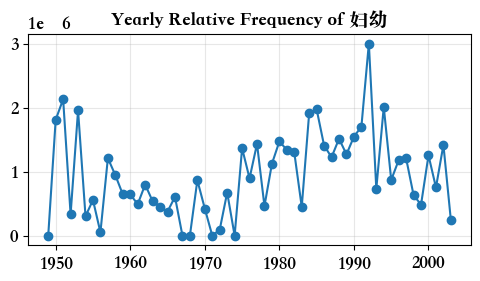

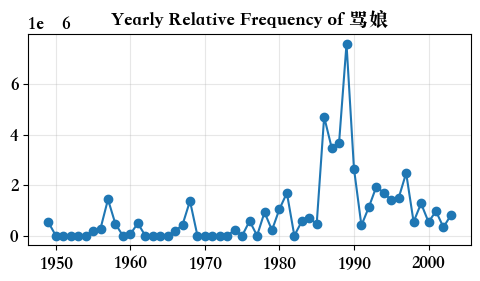

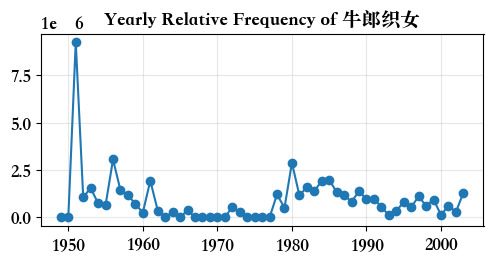

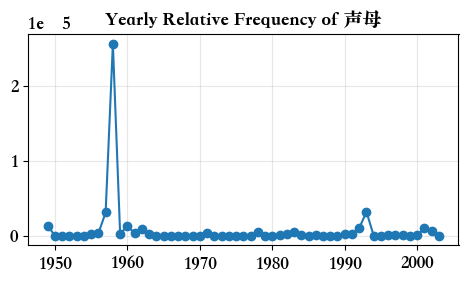

In [ ]:
# plot the frequency of the words related to women over the years
female_df = filtered_df[filtered_df['token'].str.contains("妇|母|娘|女", na=False)] # this is not the final filter, refer to graph analysis file
for name in female_df.sort_values(by='total_count', ascending=False)['token'].head(200):
    plot_word_frequency(name)